This notebook is intended to simulate what the UI will look like and is top-level

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
from scipy.stats import gaussian_kde
import altair as alt
sns.set()
import matplotlib
matplotlib.rcParams['figure.dpi'] = 144

from datetime import datetime, timedelta

from Fair_Fare.feature_utils import load_hdf
from Fair_Fare.aggregations import bin_on_time_distance
from Fair_Fare.model_utils import get_model_from_file, predict_fare
from Fair_Fare.trips import Stop, Ride
from Fair_Fare.api_interactions import price_estimate_from_lyft


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [232]:
models = {"path":"models/", "taxi":"taxi_xgb_full_reduced_params", "rideshare":"tnp_xgb_full_reduced_params" }
data = {"path":"data/","taxi":"taxi_test.h5", "rideshare":"tnp_test.h5" }

taxi_model = get_model_from_file(models['path']+models['taxi'])
taxi_data = load_hdf(data['path']+data['taxi'])

rideshare_model = get_model_from_file(models['path']+models['rideshare'])
rideshare_data = load_hdf(data['path']+data['rideshare'])



In [233]:
def text_to_fares(binned,start, end, bRideshare = True):
    time = datetime.now()
    time = time#+ timedelta(hours=int(test_trip["hour"]+24)- time.hour)
    model_estimate = {}
    
    ride = Ride(start,end, time, bRideshare, bShared = False)
    if bRideshare:
        model_estimate['rideshare_model_estimate'] = predict_fare(ride, rideshare_model)[0]
        ride.bShared = True
        ride.build_row()
        model_estimate['rideshare_shared_model_estimate'] = predict_fare(ride, rideshare_model)[0]
    else:
        model_estimate['taxi_estimate'] = predict_fare(ride, taxi_model)[0]
    lyft_estimates = price_estimate_from_lyft(ride.start.tuple,ride.end.tuple)
    
    td_tup = (ride.traveltime,ride.miles)
    binned_pth = binned.time_distance_to_bin(td_tup)
    group =  binned.df[binned.df.td_bin == binned_pth]
    return model_estimate, lyft_estimates, group

In [269]:
USER_PARAMS = {'pickup': "the bean chicago", "dropoff": "Sears tower chicago", "shared":False}

In [270]:
rideshare_binned = bin_on_time_distance(rideshare_data)
## TODO: Investigate the binning on the taxi data (time is very discrete)
taxi_binned = bin_on_time_distance(taxi_data, miles_nbins = 20, seconds_nbins = 16)

rideshare_model_pred, lyft_estimate, rideshare_group= text_to_fares(rideshare_binned,USER_PARAMS['pickup'], USER_PARAMS['dropoff'])
taxi_model_pred, taxi_estimate, taxi_group = text_to_fares(taxi_binned,USER_PARAMS['pickup'], USER_PARAMS['dropoff'],bRideshare = False)

ridshare_shared_fares = rideshare_group[rideshare_group["Shared_Trip_Authorized"] == True].Final_Fare
ridshare_fares = rideshare_group[rideshare_group["Shared_Trip_Authorized"] == False].Final_Fare
taxi_fares = taxi_group.Final_Fare

to_df = {'Rideshare shared price: ': rideshare_model_pred['rideshare_model_estimate'], 'Rideshare regular price: ': rideshare_model_pred['rideshare_shared_model_estimate'],
 'Taxi price:' :taxi_model_pred['taxi_estimate']}

In [271]:
pd.set_option("display.precision", 2)
print(pd.Series(to_df))

Rideshare shared price:      9.16
Rideshare regular price:     5.95
Taxi price:                  7.96
dtype: float64


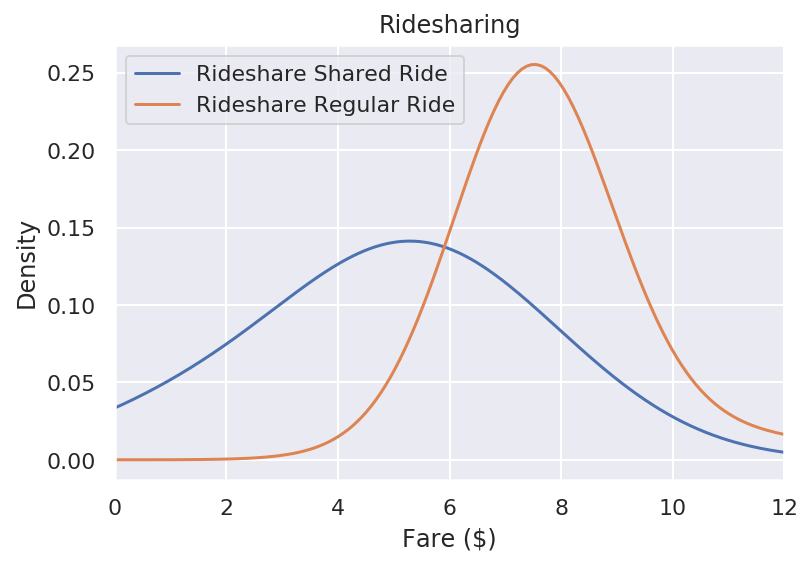

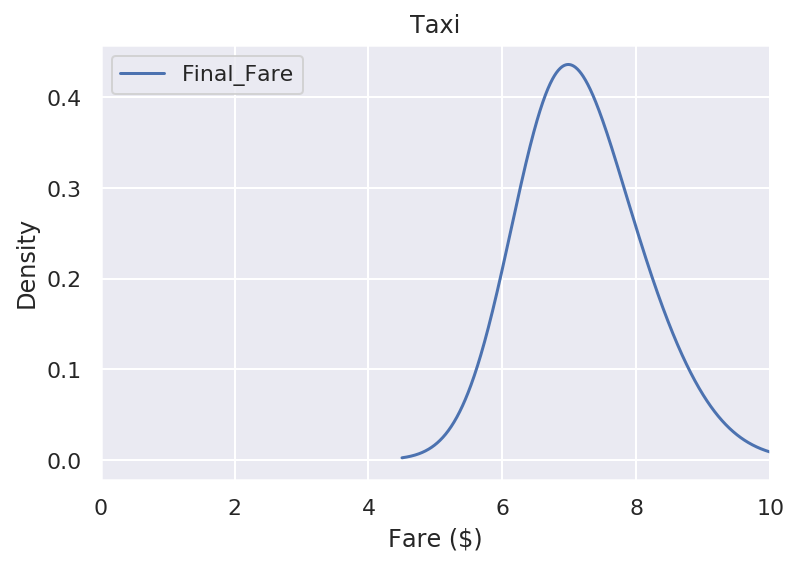

In [272]:
ax = ridshare_shared_fares.plot.kde(1, label = "Rideshare Shared Ride")
ax.set_title("Ridesharing")
ax.set_xlabel("Fare ($)")
ridshare_fares.plot.kde(1, label = "Rideshare Regular Ride")
ax.set_xlim([0,12])
ax.legend()
plt.show()

ax = taxi_fares.plot.kde(1)
ax.set_title("Taxi")
ax.set_xlabel("Fare ($)")
ax.set_xlim([0,10])
ax.legend()
plt.show()



In [70]:
taxi_model_pred, taxi_estimate, taxi_group = text_to_fares(taxi_binned,USER_PARAMS['pickup'], USER_PARAMS['dropoff'],bRideshare = False)

In [138]:
# do something with group

ridshare_shared_fares = rideshare_group[rideshare_group["Shared_Trip_Authorized"] == True].Final_Fare.values
ridshare_fares = rideshare_group[rideshare_group["Shared_Trip_Authorized"] == False].Final_Fare.values
taxi_fares = taxi_group.Final_Fare.values

def hist_and_kde(data, nbins = 50):
    gkde=gaussian_kde(data,bw_method = .8)
    grid = np.linspace(np.min(data),np.max(data),nbins)
    kde_vals = gkde.evaluate(grid)
    hist, bin_edges = np.histogram(data,nbins, density = True)
    return pd.DataFrame({'x':grid, 'y':kde_vals}) #, pd.DataFrame({'x':hist, 'y':bin_edges})

In [148]:
kde = hist_and_kde(taxi_fares, nbins = 50)
#for i in range(20):
 #   kde[str(i)] = rideshare_model_pred['shared_model_estimate'][i][0]

kde['hour'] = np.hstack((rideshare_model_pred['shared_model_estimate'], np.zeros(len(kde)-20)))

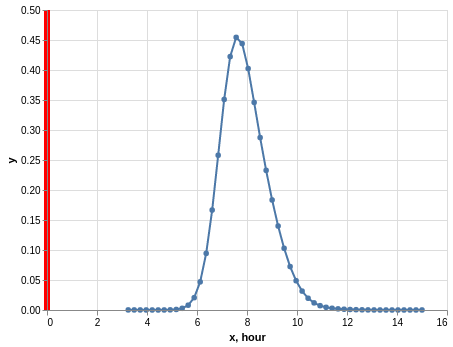

In [155]:
base = alt.Chart(kde)

slider = alt.binding_range(min=0, max=20, step=1)
select_hour = alt.selection_single(name="hour", fields=['hour'],
                                   bind=slider, init={'hour': 0})

hist = base.mark_line(point=True).encode(
    x='x',
    y='y'
)

rule = base.mark_rule(color='red').encode(
    x='hour',
    size=alt.value(5)
).add_selection(
select_hour).transform_filter(
    select_hour)

hist + rule

In [124]:
kde

,x,y,est,0,1,2,3,4,5,6,...,10,11,12,13,14,15,16,17,18,19
0,3.250000,0.000151,5,6.337977,6.383305,6.607094,5.615235,5.623502,5.640815,6.220443,...,6.590017,5.826961,6.499339,5.770545,5.695819,6.512403,5.47208,5.562726,6.607094,6.220443
1,3.489796,0.000139,5,6.337977,6.383305,6.607094,5.615235,5.623502,5.640815,6.220443,...,6.590017,5.826961,6.499339,5.770545,5.695819,6.512403,5.47208,5.562726,6.607094,6.220443
2,3.729592,0.000109,5,6.337977,6.383305,6.607094,5.615235,5.623502,5.640815,6.220443,...,6.590017,5.826961,6.499339,5.770545,5.695819,6.512403,5.47208,5.562726,6.607094,6.220443
3,3.969388,0.000073,5,6.337977,6.383305,6.607094,5.615235,5.623502,5.640815,6.220443,...,6.590017,5.826961,6.499339,5.770545,5.695819,6.512403,5.47208,5.562726,6.607094,6.220443
4,4.209184,0.000045,5,6.337977,6.383305,6.607094,5.615235,5.623502,5.640815,6.220443,...,6.590017,5.826961,6.499339,5.770545,5.695819,6.512403,5.47208,5.562726,6.607094,6.220443
5,4.448980,0.000038,5,6.337977,6.383305,6.607094,5.615235,5.623502,5.640815,6.220443,...,6.590017,5.826961,6.499339,5.770545,5.695819,6.512403,5.47208,5.562726,6.607094,6.220443
6,4.688776,0.000081,5,6.337977,6.383305,6.607094,5.615235,5.623502,5.640815,6.220443,...,6.590017,5.826961,6.499339,5.770545,5.695819,6.512403,5.47208,5.562726,6.607094,6.220443
7,4.928571,0.000270,5,6.337977,6.383305,6.607094,5.615235,5.623502,5.640815,6.220443,...,6.590017,5.826961,6.499339,5.770545,5.695819,6.512403,5.47208,5.562726,6.607094,6.220443
8,5.168367,0.000902,5,6.337977,6.383305,6.607094,5.615235,5.623502,5.640815,6.220443,...,6.590017,5.826961,6.499339,5.770545,5.695819,6.512403,5.47208,5.562726,6.607094,6.220443
9,5.408163,0.002813,5,6.337977,6.383305,6.607094,5.615235,5.623502,5.640815,6.220443,...,6.590017,5.826961,6.499339,5.770545,5.695819,6.512403,5.47208,5.562726,6.607094,6.220443
